In [ ]:
import skweak
import os
import pandas as pd
from transformers import AutoTokenizer
import pandas as pd
import ast
import torch
import gc
import shutil
import evaluate
import shutil
import numpy as np
import tokenizations
import json
from matplotlib import pyplot as plt
from torch.nn import functional
import spacy
from spacy import displacy
from collections import Counter
import sys
import os

# Get the parent directory of the current directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the parent directory to the Python path
sys.path.append(parent_dir)
from myutils import *

In [ ]:
# Load the data
path_data = '../data/'
file_name = 'dev_ws_lfs.json'
rubrics = load_rubrics(path_data + 'rubrics.json')
annotated_train_data = load_json(path_data + file_name)

In [ ]:
# calculate stats splitted by German and English
stats_de = {}
stats_en = {}
# initialize stats dict  for the individual labeling_functions
for k in annotated_train_data[0]['labeling_functions']:
    stats_de[k] ={'class':[], 'labels':[]}
for k in annotated_train_data[0]['labeling_functions']:
    stats_en[k] ={'class':[], 'labels':[]}

for an in annotated_train_data:
    c = an['label']
    lang = an['lang']
    if lang == 'en':
        for k,v in an['labeling_functions'].items():
            stats_en[k]['labels'].append(v)
            stats_en[k]['class'].append(c)
    elif lang == 'de':
         for k,v in an['labeling_functions'].items():
            stats_de[k]['labels'].append(v)
            stats_de[k]['class'].append(c)

# ANALYSIS START

In [ ]:
nlp = spacy.load("en_core_web_lg")
nlp_de = spacy.load("de_core_news_lg")
german_question_ids = [str(i) for i in range(1,9)]
th = 0.5

In [ ]:
colors = ['green', 'orange', 'red']

# Analyze individual LFs

In [ ]:
# Distribution of labels per LF
for lang, stats in {'DE': stats_de, 'EN': stats_en}.items():
    bin_items = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7,0.8,0.9,1.0]
    for k,v in stats.items():
        correct, partial_correct, incorrect = [],[],[]
        for c, l in zip(v['class'], v['labels']):
            if c == 'CORRECT':
                correct.append(l)
            elif c == 'PARTIAL_CORRECT':
                partial_correct.append(l)
            elif c == 'INCORRECT':
                incorrect.append(l)
        plt.title(lang + ' ' + k)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        correct = flat_list(correct)
        #correct = [i for i in correct if i != 0.0]
        partial_correct = flat_list(partial_correct)
        #partial_correct = [i for i in partial_correct if i != 0.0]
        incorrect = flat_list(incorrect)
        #incorrect = [i for i in incorrect if i != 0.0]
        plt.hist([correct, partial_correct, incorrect], label=['CORRECT', 'PARTIAL_CORRECT', 'INCORRECT'], color=colors)
        plt.xticks(bin_items)
        plt.legend()
        plt.show()

In [ ]:
# Share of as relevant labeled tokens based on a threshold (>=0.5)
for lang, stats in {'DE': stats_de, 'EN': stats_en}.items():
   
    for k,v in stats.items():
        relevants, unrelevants = [],[]
        for labels in v['labels']:
            relevant, unrelevant = 0,0
            for label in labels:
                for l in labels:
                    if l > th:
                        relevant+=1
                    else:
                        unrelevant+=1
            relevants.append(relevant)
            unrelevants.append(unrelevant)
        
        plt.title(lang + ' ' + k)
        plt.pie([np.sum(relevants), np.sum(unrelevants)], labels = ['relevant_token', 'unrelevant_token'],autopct='%1.1f%%')
        #plt.legend()
        plt.show()
    print(20*'-')

In [ ]:
# Share of the general labeled tokens per LF
for lang, stats in {'DE': stats_de, 'EN': stats_en}.items():
   
    for k,v in stats.items():
        relevants, unrelevants = [],[]
        for labels in v['labels']:
            relevant, unrelevant = 0,0
            for label in labels:
                for l in labels:
                    if l > 0.0:
                        relevant+=1
                    else:
                        unrelevant+=1
            relevants.append(relevant)
            unrelevants.append(unrelevant)
        
        plt.title(lang + ' ' + k)
        plt.pie([np.sum(relevants), np.sum(unrelevants)], labels = ['labeled_token', 'unlabeled_token'],autopct='%1.1f%%')
        plt.legend()
        plt.show()
    print(20*'-')

In [ ]:
# labeled tokens per LF per class
for lang, stats in {'DE': stats_de, 'EN': stats_en}.items():
    data = {'CORRECT': [],'PARTIAL_CORRECT': [], 'INCORRECT': []}
    lfs = list(stats.keys())
    for k,v in stats.items():
        correct, partial_correct, incorrect = [],[],[]
        for c, l in zip(v['class'], v['labels']):
            if c == 'CORRECT':
                correct.append(l)
            elif c == 'PARTIAL_CORRECT':
                partial_correct.append(l)
            elif c == 'INCORRECT':
                incorrect.append(l)
        # flatten and check if relevant -> <= 0.5
        correct = flat_list(correct)
        correct = len([i for i in correct if i >= th])
        partial_correct = flat_list(partial_correct)
        partial_correct = len([i for i in partial_correct if i >= th])
        incorrect = flat_list(incorrect)
        incorrect = len([i for i in incorrect if i > th])
        data['CORRECT'].append(correct)
        data['PARTIAL_CORRECT'].append(partial_correct)
        data['INCORRECT'].append(incorrect)
    
    plt.title(lang + ' Number of relevant token per LF')
    plt.xlabel('Data')
    plt.ylabel('Frequency')
    for l,c in zip(['CORRECT', 'PARTIAL_CORRECT', 'INCORRECT'], colors):
        plt.bar(lfs, data[l] ,label=l, color=c)
        plt.ylim(0,4000)
        plt.xticks(lfs, rotation=90)
        plt.legend()
        plt.show()
    #plt.bar(lfs, data[] ,label='PARTIAL_CORRECT', color='orange')
    #plt.bar(lfs, data['INCORRECT'] ,label='INCORRECT', color='red')
    

In [ ]:
# How long and how many key elements does a LF detect?
for lang, stats in {'DE': stats_de, 'EN': stats_en}.items():
    data = {'CORRECT': {'avg_relation': [], 'avg_len_rubrics': [], 'avg_token_per_element': []},'PARTIAL_CORRECT': {'avg_relation': [], 'avg_len_rubrics': [], 'avg_token_per_element': []}, 'INCORRECT': {'avg_relation': [], 'avg_len_rubrics': [], 'avg_token_per_element': []}}
    lfs = list(stats.keys())
    for k,v in stats.items():
        correct, partial_correct, incorrect = [],[],[]
        for c, l in zip(v['class'], v['labels']):
            if c == 'CORRECT':
                correct.append(l)
            elif c == 'PARTIAL_CORRECT':
                partial_correct.append(l)
            elif c == 'INCORRECT':
                incorrect.append(l)
        correct = [silver2target(labels, th) for labels in correct]
        #correct = [i for i in correct if i >= th]
        partial_correct = [silver2target(labels, th) for labels in partial_correct]
        #partial_correct = len([i for i in partial_correct if i >= th])
        incorrect = [silver2target(labels, th) for labels in incorrect]
        
        # dynamic values for every LF
        relations, len_rubrics, num_token_per_element = [],[], []
        for i,c in enumerate([correct, partial_correct, incorrect]):
            rels = [relation(l) for l in c]
            len_rubric = [len(rubric_length(l)) for l in c]
            token_per_element = [np.average(rubric_length(l)) for l in c]
            token_per_element = [t for t in token_per_element if not np.isnan(t)]
            avg_relations = np.average(rels)
            avg_len_rubrics = np.average(len_rubric)
            if len(token_per_element) == 0:
                token_per_element.append(0)
            avg_token_per_element = np.average(token_per_element)
            #relations.append(avg_relations)
            #len_rubrics.append(avg_len_rubrics)
            #num_token_per_element.append(avg_len_rubrics)
            if i == 0: 
                l = 'CORRECT'
            elif i == 1: 
                l = 'PARTIAL_CORRECT'
            elif i == 2: 
                l = 'INCORRECT'
            data[l]['avg_relation'].append(avg_relations)
            data[l]['avg_len_rubrics'].append(avg_len_rubrics) 
            data[l]['avg_token_per_element'].append(avg_token_per_element) 
    
    # TODO adapt it here
    plt.xlabel('LFs')
    #plt.ylabel() 
    for l in ['avg_relation', 'avg_len_rubrics', 'avg_token_per_element']:
        plt.title(lang + ' Stats ' + l)
        plt.plot(lfs, data['CORRECT'][l] ,label='CORRECT')
        plt.plot(lfs, data['PARTIAL_CORRECT'][l] ,label='PARTIAL_CORRECT')
        plt.plot(lfs, data['INCORRECT'][l],label='INCORRECT')
        plt.legend()
        plt.xticks(lfs, rotation=90)
        plt.show()


# Aggregation functions
Analyze how the different aggregation techniches distribute the labels

In [ ]:
GLOBAL_NORMALIZE = False

def global_normalize(data):
    # finding min and max value
    min_value = 100
    max_value = -100
    max_vals = []
    min_vals = []
    for d in data:
        v_min = np.min(d)
        v_max = np.max(d)
        if v_min < min_value:
            min_value = v_min
            min_vals.append(min_value)
        if v_max > max_value:
            max_value = v_max
            max_vals.append(max_value)
    print('max', max_vals, 'min', min_vals)
    range_val = max_value - min_value
    data_norm = [[(l - min_value) / range_val for l in d] for d in data]
    return data_norm

In [ ]:
# different aggregation functions
# exclude all hard match functions
#exclude = ['LF_word_alginment', 'LF_dep_match_without_stopwords', 'LF_dep_match', 'LF_tag_match', 'LF_stem_match', 'LF_pos_match_without_stopwords', 'LF_lemma_match_without_stopwords','LF_pos_match' , 'LF_pos_match', 'LF_noun_phrase']
exclude=[]
#exclude = ['LF_dep_match_without_stopwords', 'LF_dep_match', 'LF_tag_match','LF_pos_match_without_stopwords', 'LF_lemma_match_without_stopwords', 'LF_pos_match', 'LF_noun_phrases' ]
#exclude = ['LF_parahrase_detection_candidates', 'LF_parahrase_detection_sentences', 'LF_bleu_candidates', 'LF_jaccard_similarity', 'LF_edit_distance']
annotations_train = extract_annotations(annotated_train_data, exclude_LFs=exclude)

#annotations_train = extract_annotations_only_LFs(annotated_train_data, lfs=['LF_parahrase_detection_sentences', 'LF_parahrase_detection_candidates'])
#annotations_dev = extract_annotations_only_LFs(annotated_dev_data, lfs=['LF_parahrase_detection_sentences', 'LF_parahrase_detection_candidates'])

for lang in ['de', 'en']:
    for mode in ['average', 'max', 'average_nonzero', 'sum']:
        stats = {
            'CORRECT':[],
            'PARTIAL_CORRECT': [],
            'INCORRECT': []
        }
        labels = []
        for a, an in zip(annotations_train, annotated_train_data):
            y = aggregate_soft_labels(a, mode)
            if not GLOBAL_NORMALIZE:
                y = y#normalize(y)
            labels.append(y)
        if GLOBAL_NORMALIZE:
            labels = global_normalize(labels)
        print(mode, GLOBAL_NORMALIZE)
        for an, label in zip(annotated_train_data, labels):
            c = an['label']
            l = an['lang']
            if l  == lang:
                #for mode in ['average', 'max', 'average_nonzero', 'sum']:
                stats[c].append(label)
        
        bin_items = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        #counts, bins = np.histogram(x,bins=bin_items)
        plt.title(lang.upper() + ' ' + mode + '_global_norm='+ str(GLOBAL_NORMALIZE))
        plt.xlabel('Data')
        plt.ylabel('Frequency')
        correct = flat_list(stats['CORRECT'])
        partial_correct = flat_list(stats['PARTIAL_CORRECT'])
        incorrect = flat_list(stats['INCORRECT'])
        normalized_data = []
        weights = []
        
        for d in [correct, partial_correct, incorrect]:
            w = np.ones_like(d) / len(d)
            weights.append(w)
        plt.hist([correct, partial_correct, incorrect], bins=bin_items, weights=weights, label=['CORRECT', 'PARTIAL_CORRECT', 'INCORRECT'])
        plt.xticks(bin_items)
        plt.legend()

        plt.show()

In [ ]:
# different aggregation functions
# exclude all hard match functions
#exclude = ['LF_word_alginment', 'LF_dep_match_without_stopwords', 'LF_dep_match', 'LF_tag_match', 'LF_stem_match', 'LF_shape_match', 'LF_pos_match_without_stopwords', 'LF_lemma_match_without_stopwords', 'LF_pos_match', 'LF_lemma_match', 'LF_noun_phrase']
exclude=[]
#exclude = ['LF_dep_match_without_stopwords', 'LF_dep_match', 'LF_tag_match','LF_pos_match_without_stopwords', 'LF_lemma_match_without_stopwords', 'LF_pos_match', 'LF_noun_phrases' ]
#exclude = ['LF_parahrase_detection_candidates', 'LF_parahrase_detection_sentences', 'LF_bleu_candidates', 'LF_jaccard_similarity', 'LF_edit_distance']
annotations_train = extract_annotations(annotated_train_data, exclude_LFs=exclude)
#annotations_train = extract_annotations_only_LFs(annotated_train_data, lfs=['LF_parahrase_detection_sentences', 'LF_parahrase_detection_candidates'])
#annotations_dev = extract_annotations_only_LFs(annotated_dev_data, lfs=['LF_parahrase_detection_sentences', 'LF_parahrase_detection_candidates'])

def global_normalize(data):
    # finding min and max value
    min_value = 100
    max_value = -100
    max_vals = []
    min_vals = []
    for d in data:
        v_min = np.min(d)
        v_max = np.max(d)
        if v_min < min_value:
            min_value = v_min
            min_vals.append(min_value)
        if v_max > max_value:
            max_value = v_max
            max_vals.append(max_value)
    print('max', max_vals, 'min', min_vals)
    #min_value = min_vals[0]
    #max_value = max_vals[0]
    #min_value = np.average(min_vals)
    #max_value = np.average(max_vals)
    range_val = max_value - min_value
    data_norm = [[(l - min_value) / range_val for l in d] for d in data]
    return data_norm

for mode in ['average', 'max', 'average_nonzero', 'sum']:
        stats = {
            'CORRECT':[],
            'PARTIAL_CORRECT': [],
            'INCORRECT': []
        }
        labels = []
        for a, an in zip(annotations_train, annotated_train_data):
            y = aggregate_soft_labels(a, mode)
            y= normalize(y)
            labels.append(y)
        for an, label in zip(annotated_train_data, labels):
            c = an['label']
            
            #for mode in ['average', 'max', 'average_nonzero', 'sum']:
            stats[c].append(label)
        
        bin_items = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        #counts, bins = np.histogram(x,bins=bin_items)
        plt.title(mode)
        plt.xlabel('Data')
        plt.ylabel('Frequency')
        correct = flat_list(stats['CORRECT'])
        partial_correct = flat_list(stats['PARTIAL_CORRECT'])
        incorrect = flat_list(stats['INCORRECT'])
        normalized_data = []
        weights = []
        
        for d in [correct, partial_correct, incorrect]:
            w = np.ones_like(d) / len(d)
            weights.append(w)
        plt.hist([correct, partial_correct, incorrect], bins=bin_items, weights=weights, label=['CORRECT', 'PARTIAL_CORRECT', 'INCORRECT'])
        plt.xticks(bin_items)
        plt.legend()
            #n, bins = np.histogram(d, bins=bin_items,density=True)
            #n = n / n.sum()
            #print(n)
            #normalized_data.append(n)
            #plt.bar(normalized_data, bins=bin_items)
        #plt.hist(normalized_data[1],ins=bin_items)
        #plt.hist(normalized_data[2], ins=bin_items)
       
        #data = np.concatenate([correct, partial_correct, incorrect])
        #n, bins = np.histogram(data, bins=bin_items,density=True)
        # Normalize the histogram
        #n = n / n.sum()
        #print(n)
        #plt.hist(n, bins=bin_items, )
        # Plot the normalized histogram
        #plt.bar(bin_items, n[0], width=0.05)
        #plt.bar(bin_items, n[1], width=0.05)
        #plt.bar(bin_items, n[2], width=0.05)

        plt.show()

# Analyze Rubric

In [ ]:
german_ids = [str(i) for i in range(1,10)]

x_de= []
x_en= []
x_number_of_tokens_de = []
x_number_of_tokens_en = []
for k in rubrics.keys():
    if k in german_ids:
        x_de.append(len(rubrics[k]['key_element']))
        x_number_of_tokens_de.append(np.average([len(nlp_de(k)) for k in rubrics[k]['key_element']]))
    else:
        x_en.append(len(rubrics[k]['key_element']))
        x_number_of_tokens_en.append(np.average([len(nlp(k)) for k in rubrics[k]['key_element']]))

print('Average key elements DE', np.average(x_de))
print('Average key elements EN', np.average(x_en))
print('Average tokens per key element DE', np.average(x_number_of_tokens_de))
print('Average tokens per key element EN', np.average(x_number_of_tokens_en))
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Number of Key Elements in the Scoring Rubrics')
plt.hist([x_de, x_en], label=['DE', 'EN'], color=['orange', 'blue'])
x_axis = range(0,21)
plt.xticks(x_axis)
plt.legend()
plt.show()

# Analyze Annotated Key Elements

In [ ]:
for language in ['de', 'en']:
    relations_correct, relations_partial, relations_incorrect = [], [],[]
    len_rubrics_correct, len_rubrics_partial, len_rubrics_incorrect = [], [],[]
    len_rubrics_average_correct, len_rubrics_average_partial, len_rubrics_average_incorrect = [], [],[]
    for an, labels in zip(annotated_train_data, silver_labels):
        lang = an['lang']
        c = an['label']
        if lang == language:
            true_labels = silver2target(labels,th=th)
            rel = relation(true_labels)
            len_rubrics = rubric_length(true_labels)
            if len(len_rubrics) > 0:
                len_rubrics_average = np.average(len_rubrics)
            else:
                len_rubrics_average = 0
            if c == 'CORRECT':
                relations_correct.append(rel)
                len_rubrics_correct.append(len(len_rubrics))
                len_rubrics_average_correct.append(len_rubrics_average)
            elif c == 'PARTIAL_CORRECT':
                relations_partial.append(rel)
                len_rubrics_partial.append(len(len_rubrics))
                len_rubrics_average_partial.append(len_rubrics_average)
            elif c == 'INCORRECT':
                relations_incorrect.append(rel)
                len_rubrics_incorrect.append(len(len_rubrics))
                len_rubrics_average_incorrect.append(len_rubrics_average)
    
    print(language.upper() +' Relation:','CORRECT', np.average(relations_correct), 'PARTIAL_CORRECT', np.average(relations_partial),'INCORRECT', np.average(relations_incorrect))
    
    plot_hist({'CORRECT': len_rubrics_average_correct, 'PARTIAL_CORRECT': len_rubrics_average_partial, 'INCORRECT': len_rubrics_average_incorrect}, bins=range(0,50,5), title=language.upper()+' Number of tokens in key element')         
    print(language.upper() + ' Average len (tokens):', 'CORRECT',np.average(len_rubrics_average_correct),'PARTIAL_CORRECT', np.average(len_rubrics_average_partial), 'INCORRECT', np.average(len_rubrics_average_incorrect))
    
    plot_hist({'CORRECT': len_rubrics_correct, 'PARTIAL_CORRECT': len_rubrics_partial, 'INCORRECT': len_rubrics_incorrect}, bins=range(0,20,2), title=language.upper() + ' Number of key elements in answer')         
    print(language.upper() + ' Average number of rubrics in answer:', 'CORRECT',np.average(len_rubrics_correct), 'PARTIAL_CORRECT',np.average(len_rubrics_partial),'INCORRECT', np.average(len_rubrics_incorrect))

## Question specific data

In [ ]:
for question_id in np.unique(list(rubrics.keys())):
    relations_correct, relations_partial, relations_incorrect = [], [],[]
    len_rubrics_correct, len_rubrics_partial, len_rubrics_incorrect = [], [],[]
    len_rubrics_average_correct, len_rubrics_average_partial, len_rubrics_average_incorrect = [], [],[]
    for an, labels in zip(annotated_train_data, silver_labels):
        q_id = an['question_id']
        c = an['label']
        if q_id == question_id:
            true_labels = silver2target(labels)
            rel = relation(true_labels)
            len_rubrics = rubric_length(true_labels)
            if len(len_rubrics) > 0:
                len_rubrics_average = np.average(len_rubrics)
            else:
                len_rubrics_average = 0
            if c == 'CORRECT':
                relations_correct.append(rel)
                len_rubrics_correct.append(len(len_rubrics))
                len_rubrics_average_correct.append(len_rubrics_average)
            elif c == 'PARTIAL_CORRECT':
                relations_partial.append(rel)
                len_rubrics_partial.append(len(len_rubrics))
                len_rubrics_average_partial.append(len_rubrics_average)
            elif c == 'INCORRECT':
                relations_incorrect.append(rel)
                len_rubrics_incorrect.append(len(len_rubrics))
                len_rubrics_average_incorrect.append(len_rubrics_average)
    
    print(question_id +' Relation:','CORRECT', np.average(relations_correct), 'PARTIAL_CORRECT', np.average(relations_partial),'INCORRECT', np.average(relations_incorrect))
    
    plot_hist({'CORRECT': len_rubrics_average_correct, 'PARTIAL_CORRECT': len_rubrics_average_partial, 'INCORRECT': len_rubrics_average_incorrect}, bins=range(0,50,5), title=question_id+' Number of tokens in key element')         
    print(question_id + ' Average len (tokens):', 'CORRECT',np.average(len_rubrics_average_correct),'PARTIAL_CORRECT', np.average(len_rubrics_average_partial), 'INCORRECT', np.average(len_rubrics_average_incorrect))
    
    plot_hist({'CORRECT': len_rubrics_correct, 'PARTIAL_CORRECT': len_rubrics_partial, 'INCORRECT': len_rubrics_incorrect}, bins=range(0,20,2), title=question_id + ' Number of key elements in answer')         
    print(question_id+ ' Average number of rubrics in answer:', 'CORRECT',np.average(len_rubrics_correct), 'PARTIAL_CORRECT',np.average(len_rubrics_partial),'INCORRECT', np.average(len_rubrics_incorrect))
    print(30*'-' + '\n')

# Analysis Dataset
Analyze the SAF dataset itself

In [ ]:
X_train = load_json('../data/training_dataset.json')
X_dev = load_json('../data/dev_dataset.json')
X_test = load_json('../data/test_dataset.json')


In [ ]:
def get_lang_dist(data):
    stats={'en':0, 'de':0}
    for d in data:
        stats[d['lang']] += 1
    return stats

def get_class_dist(data):
    stats={'CORRECT':0, 'PARTIAL_CORRECT':0, 'INCORRECT': 0}
    for d in data:
        stats[d['label']] += 1
    return stats

In [ ]:
stats = get_lang_dist(X_train)
print(stats)
plt.title('Dataset language split')
plt.pie([stats['de'], stats['en']], labels = list(stats.keys()),autopct='%1.1f%%')
plt.legend()
plt.show()

stats = get_class_dist(X_train)
print(stats)
plt.title('Dataset class split')
plt.pie([stats['CORRECT'], stats['PARTIAL_CORRECT'], stats['INCORRECT']], labels = list(stats.keys()),autopct='%1.1f%%')

plt.legend()
plt.show()




In [ ]:
stats = get_lang_dist(X_dev)
print(stats)
plt.title('Dataset language split')
plt.pie([stats['de'], stats['en']], labels = list(stats.keys()),autopct='%1.1f%%')
plt.legend()
plt.show()

stats = get_class_dist(X_dev)
print(stats)
plt.title('Dataset class split')
plt.pie([stats['CORRECT'], stats['PARTIAL_CORRECT'], stats['INCORRECT']], labels = list(stats.keys()),autopct='%1.1f%%')

plt.legend()
plt.show()

In [ ]:
stats = get_lang_dist(X_test)
print(stats)
plt.title('Dataset language split')
plt.pie([stats['de'], stats['en']], labels = list(stats.keys()),autopct='%1.1f%%')
plt.legend()
plt.show()

stats = get_class_dist(X_test)
print(stats)
plt.title('Dataset class split')
plt.pie([stats['CORRECT'], stats['PARTIAL_CORRECT'], stats['INCORRECT']], labels = list(stats.keys()),autopct='%1.1f%%')

plt.legend()
plt.show()

In [75]:
X_train = load_json('../data/training_dataset.json')
X_dev = load_json('../data/dev_dataset.json')
X_test = load_json('../data/test_dataset.json')


In [78]:
def get_lang_dist(data):
    stats={'en':0, 'de':0}
    for d in data:
        stats[d['lang']] += 1
    return stats

def get_class_dist(data):
    stats={'CORRECT':0, 'PARTIAL_CORRECT':0, 'INCORRECT': 0}
    for d in data:
        stats[d['label']] += 1
    return stats

{'en': 2046, 'de': 1620}


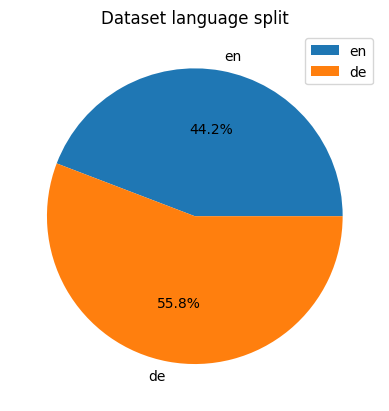

{'CORRECT': 1973, 'PARTIAL_CORRECT': 1369, 'INCORRECT': 324}


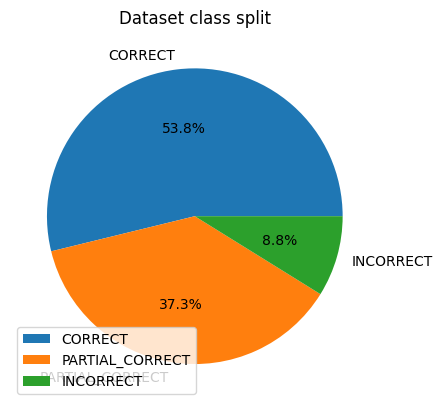

In [83]:
stats = get_lang_dist(X_train)
print(stats)
plt.title('Dataset language split')
plt.pie([stats['de'], stats['en']], labels = list(stats.keys()),autopct='%1.1f%%')
plt.legend()
plt.show()

stats = get_class_dist(X_train)
print(stats)
plt.title('Dataset class split')
plt.pie([stats['CORRECT'], stats['PARTIAL_CORRECT'], stats['INCORRECT']], labels = list(stats.keys()),autopct='%1.1f%%')

plt.legend()
plt.show()




{'en': 491, 'de': 426}


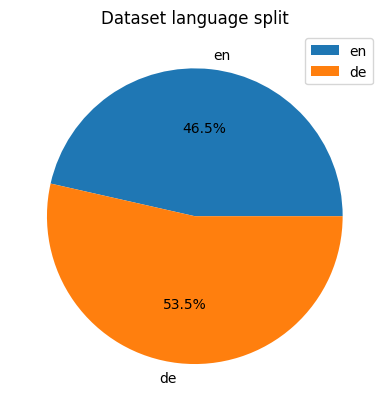

{'CORRECT': 496, 'PARTIAL_CORRECT': 336, 'INCORRECT': 85}


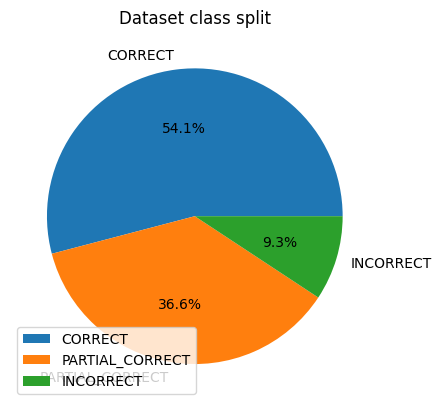

In [84]:
stats = get_lang_dist(X_dev)
print(stats)
plt.title('Dataset language split')
plt.pie([stats['de'], stats['en']], labels = list(stats.keys()),autopct='%1.1f%%')
plt.legend()
plt.show()

stats = get_class_dist(X_dev)
print(stats)
plt.title('Dataset class split')
plt.pie([stats['CORRECT'], stats['PARTIAL_CORRECT'], stats['INCORRECT']], labels = list(stats.keys()),autopct='%1.1f%%')

plt.legend()
plt.show()

{'en': 444, 'de': 361}


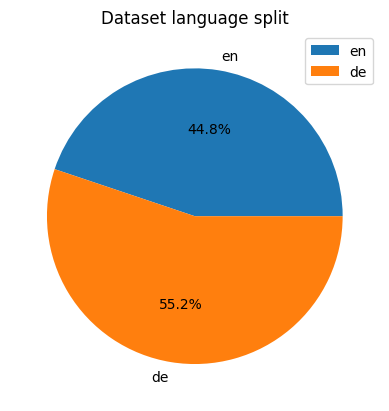

{'CORRECT': 418, 'PARTIAL_CORRECT': 311, 'INCORRECT': 76}


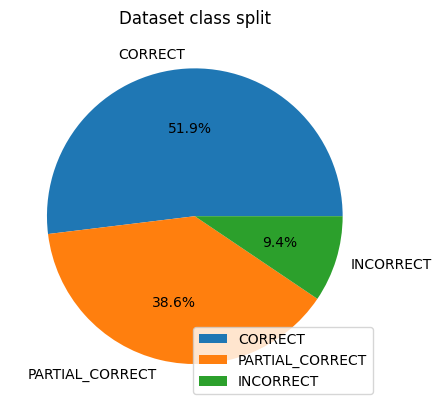

In [85]:
stats = get_lang_dist(X_test)
print(stats)
plt.title('Dataset language split')
plt.pie([stats['de'], stats['en']], labels = list(stats.keys()),autopct='%1.1f%%')
plt.legend()
plt.show()

stats = get_class_dist(X_test)
print(stats)
plt.title('Dataset class split')
plt.pie([stats['CORRECT'], stats['PARTIAL_CORRECT'], stats['INCORRECT']], labels = list(stats.keys()),autopct='%1.1f%%')

plt.legend()
plt.show()

In [60]:
# Combined Plot
c_stats = {'CORRECT':[],'PARTIAL_CORRECT':[],'INCORRECT':[] }
stats = {'de': c_stats, 'en': c_stats}
for an in annotated_train_data:
    lang = an['lang']
    student_answer = an['student_answer']
    label = an['label']
    inputs = tokenizer.encode(student_answer, return_special_tokens_mask=False)
    len_seq = len(inputs)-2 # ignore cls and sep token
    stats[lang][label].append(len_seq)
    
plt.xlabel('Length')
plt.ylabel('Occurrences')
plt.title('Length of student answer')
plt.hist([stats['de']['CORRECT'], stats['de']['PARTIAL_CORRECT'],stats['de']['INCORRECT'],stats['en']['CORRECT'], stats['en']['PARTIAL_CORRECT'],stats['en']['INCORRECT']], label=['de_correct', 'de_partial_correct', 'de_incorrect', 'en_correct', 'en_partial_correct', 'en_incorrect'], bins=range(0,300, 20))
plt.legend()
plt.show()

NameError: name 'tokenizer' is not defined

In [ ]:
# Separate plots
for language in ['en', 'de']:
    stats = {'CORRECT':[],'PARTIAL_CORRECT':[],'INCORRECT':[]}
    for an in annotated_train_data:
        lang = an['lang']
        student_answer = an['student_answer']
        label = an['label']
        if lang == language:
            inputs = tokenizer.encode(student_answer, return_special_tokens_mask=False)
            len_seq = len(inputs)-2 # ignore cls and sep token
            stats[label].append(len_seq)

    plt.xlabel('Length')
    plt.ylabel('Occurrences')
    plt.title(language.upper()+' Length of student answer')
    plt.hist([stats['CORRECT'], stats['PARTIAL_CORRECT'],stats['INCORRECT']], label=list(stats.keys()), bins=range(0,300, 20))
    plt.legend()
    plt.show()
    
    plt.title(language.upper()+' Class split')
    plt.pie([len(stats['CORRECT']), len(stats['PARTIAL_CORRECT']), len(stats['INCORRECT'])], labels = list(stats.keys()),autopct='%1.1f%%')
    plt.legend()
    plt.show()

In [ ]:
questions = [x['question_id'] for x in annotated_train_data]
c = Counter(questions)
print(c)
plt.title('Dataset question share')

plt.pie(list(c.values()), labels = list(c.keys()))
plt.legend()
plt.show()

In [ ]:
stats={'en':0, 'de':0}
langs = [x['lang'] for x in annotated_train_data]
for lang in langs:
    stats[lang] += 1
plt.title('Dataset DE/EN split')
plt.pie([stats['de'], stats['en']], labels = list(stats.keys()),autopct='%1.1f%%')
plt.legend()
plt.show()

# TMP

In [ ]:
# What are the words that a LF detect 
from collections import Counter

def get_annotated_text_per_LF(is_word_level=False, th=0.5):
    result = {}
    for lang, stats in {'DE': stats_de, 'EN': stats_en}.items():
        result[lang] = {}
        for k in stats.keys():
            labeled_tokens = []
            for text, labels, qid in zip(X_train['student_answer'] ,stats[k]['labels'], X_train['question_id']):
                # tokenize respective the language
                if qid in german_question_ids:
                    tokens = nlp_de(text)
                else:
                    tokens = nlp(text)
                hard_labels = silver2target(labels, th=th)
                indicies = get_idxs_elements(hard_labels)
                labeled_tokens.append([tokens[i[0]:i[1]] for i in indicies])
            labeled_tokens = flat_list(labeled_tokens)
            if is_word_level:
                labeled_tokens = [t.text for doc in labeled_tokens for t in doc]
            c = Counter(labeled_tokens)
            result[lang][k] = sorted(dict(c.most_common(10)).items(), key=lambda pair: pair[1], reverse=True)
    return result

result_word_level = get_annotated_text_per_LF(is_word_level=True,th=th)
for i, result in enumerate([result_word_level]):
    if i == 0: print('WORD LEVEL STATS') 
    else: print('PHRASE LEVEL STATS') 
    for lang in ['DE', 'EN']:
        lfs = result[lang].keys()
        for lf in lfs:
            print(lf)
            print(result[lang][lf])
            print(20*'-')
